Wahlpflichtfach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**<< 13 - TensorFlow - Hands On**](13_TensorFlow_Hands_On.ipynb)

---

# 14 - Tensorflow - Weitere Themen

- [Evaluation](#Evaluation)
- [Regularization](#Regularization)
- [Ensembles](#Ensembles)
- [Hyperparameter Optimization](#Hyperparameter-Optimization)

In [1]:
from pathlib import Path
from datetime import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Average, Maximum
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision, \
    TopKCategoricalAccuracy, TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import Input, Model

from keras_tuner import HyperParameters, BayesianOptimization

2023-03-11 08:39:16.335149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 08:39:16.557018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 08:39:16.557042: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 08:39:17.494752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

root_dir = Path.cwd()

In [3]:
print(tf.__version__)

2.11.0


## Dataset

 Der Datensatz enthält 150 Datenpunkte wobei jeweils 50 zu den drei Schwertlilien Arten (Setosa, Virginica, Versicolor). Der Datensatz beinhaltet zu einem Label dabei vier Features:
 1) Spalte **sepal.length** =  Länge des Kelchblattes (Sepalum)
2) Spalte **sepal.width** = Breite des Kelchblattes (Sepalum)
3) Spalte **petal.length** = Länge des Kronblattes (Petalum)
4) Spalte **petal.width** = Breite des Kronblattes (Petalum)

In [4]:
iris = load_iris(as_frame=True)
iris_df = iris.frame
iris_df['Label'] = iris.target_names[iris_df['target']]
iris_df = iris_df.drop('target', axis=1)

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


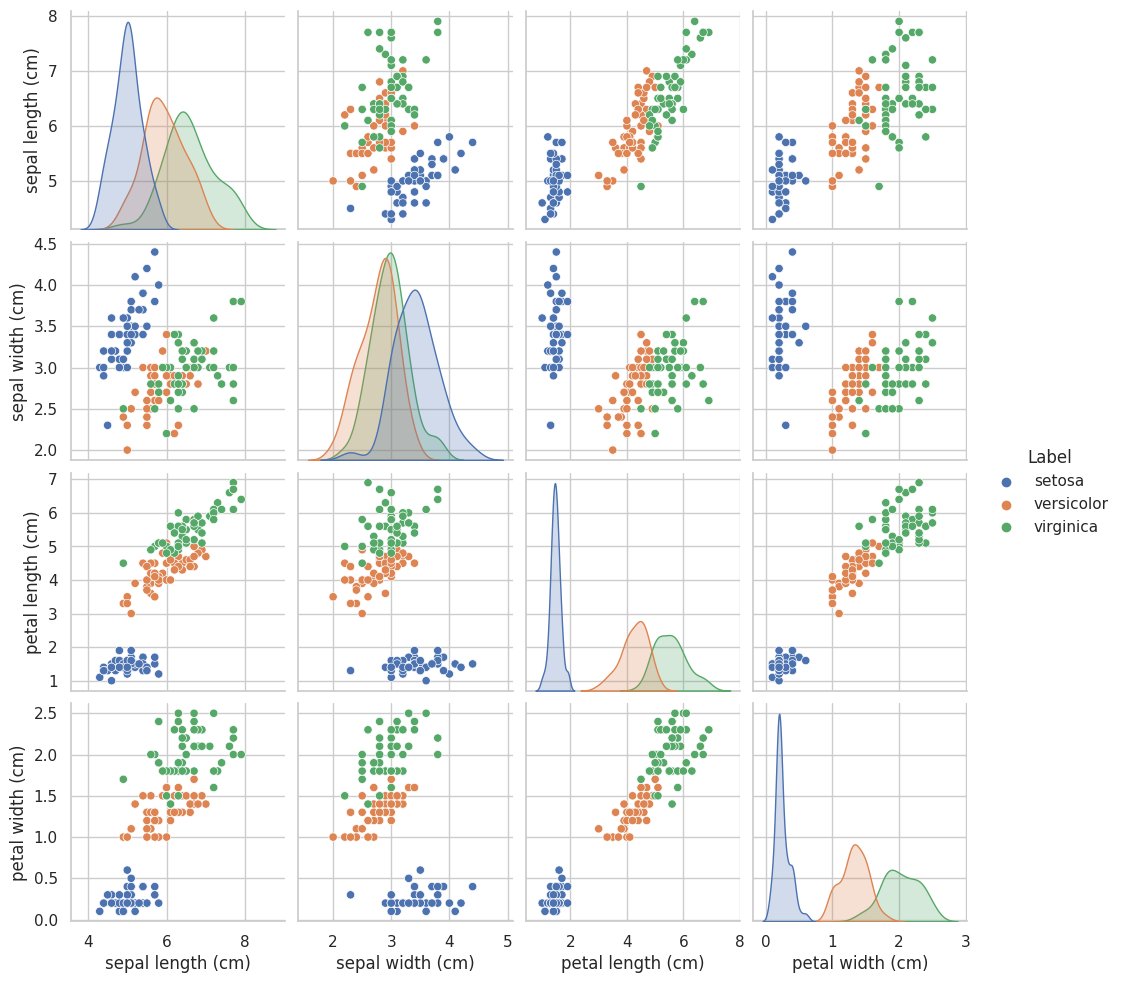

In [5]:
sns.set_theme(style="whitegrid")
sns.pairplot(iris_df, hue="Label")

In [6]:
y = pd.get_dummies(iris_df["Label"])
x = iris_df.drop('Label', axis=1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Helpers

In [8]:
def compile_model(model, metrics: list = None) -> None:
    _metrics = [
        CategoricalAccuracy(),
    ]

    model.compile(optimizer=Adam(learning_rate=0.01), loss="categorical_crossentropy",
                metrics=(metrics if metrics else _metrics))

def fit_model(model, x, y, additional_callbacks: list = None) -> None:
    log_dir = root_dir / "logs" / datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
    callbacks = [TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True,
                             profile_batch=2)]

    if additional_callbacks:
        callbacks += additional_callbacks

    model.fit(x=x, y=y, validation_split= 0.2, epochs=15,
            callbacks=callbacks)

def evalate_model(model, x, y) -> None:
    loss, acc, rec, prec, top_k, tp, fp, tn, fn = model.evaluate(x, y)
    print(f"""
    Loss:               {loss:.3f}
    Accuracy:           {acc:.2%}
    Top K Accuracy:     {top_k:.2%}

    Recall:             {rec:.3f}
    Precision           {prec:.3f}

    True Positives      {tp:n}
    False Positives     {fp:n}
    True Negatives      {tn:n}
    False Negatives     {fn:n}
    """)

## Evaluation

In [9]:
# Create Multilayer Perceptron (Feedforward Neural Network)
mlp = Sequential(name="simple_mlp")
mlp.add(Dense(8, activation="relu", input_dim=4))
mlp.add(Dense(3, activation="softmax"))

2023-03-11 08:39:23.689545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-11 08:39:23.689585: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 08:39:23.689638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-03-11 08:39:23.689986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
mlp.summary()

Model: "simple_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


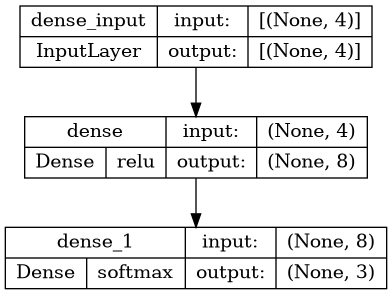

In [11]:
plot_model(mlp, show_shapes=True, show_layer_activations=True)

**Metriken**

Weitere infos zu den Metriken finden sie in der [Keras Doku](https://keras.io/api/metrics/). Beispielweise können für Klassifikationsprobleme die folgenden Metriken verwendet werden:
- Top k Categorical Accuracy
- Categorical Crossentropy
- True Positives
- False Positives
- True Negatives
- False Negatives
- Precision
- Recall

In [12]:
metrics = [
    CategoricalAccuracy(),
    TopKCategoricalAccuracy(),
    Recall(),
    Precision(),

    TruePositives(),
    FalsePositives(),
    TrueNegatives(),
    FalseNegatives()
]

In [36]:
compile_model(mlp, metrics)
fit_model(mlp, x_train, y_train)

Epoch 1/15


2023-03-11 08:43:10.543312: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:43:10.543338: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:43:10.543536: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.0262 - categorical_accuracy: 0.6857 - top_k_categorical_accuracy: 1.0000 - recall: 0.5371 - precision: 0.9400 - true_positives: 94.0000 - false_positives: 6.0000 - true_negatives: 344.0000 - false_negatives: 81.0000

2023-03-11 08:43:11.160167: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:43:11.160194: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:43:11.252123: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:43:11.252896: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:43:11.253208: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:43:10/plugins/profile/2023_03_11_08_43_11/fedora.xplane.pb


3/3 [==============================] - 1s 198ms/step - loss: 1.0261 - categorical_accuracy: 0.6462 - top_k_categorical_accuracy: 1.0000 - recall: 0.4821 - precision: 0.9307 - true_positives: 94.0000 - false_positives: 7.0000 - true_negatives: 383.0000 - false_negatives: 101.0000 - val_loss: 0.9758 - val_categorical_accuracy: 0.2857 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 6.0000 - val_true_negatives: 36.0000 - val_false_negatives: 21.0000
Epoch 2/15
3/3 [==============================] - 0s 32ms/step - loss: 1.0024 - categorical_accuracy: 0.3333 - top_k_categorical_accuracy: 1.0000 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - false_positives: 18.0000 - true_negatives: 150.0000 - false_negatives: 84.0000 - val_loss: 0.9607 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00

**Tensorboard**

Tensorboard ist ein Built-In Werkzeug von Tensorflow für die Visualisierung zur Evaluation von neuronalen Netzen. Der Vorteil liegt hierbei

In [37]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 10360), started 0:03:52 ago. (Use '!kill 10360' to kill it.)

**Evaluation**

Mit hilfe der `evaluate` Methode können sie für die Testdaten die vorher definierten Metriken errechnen lassen.

In [38]:
evalate_model(mlp, x_test, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 0.7594 - categorical_accuracy: 0.7111 - top_k_categorical_accuracy: 1.0000 - recall: 0.2889 - precision: 0.5000 - true_positives: 13.0000 - false_positives: 13.0000 - true_negatives: 77.0000 - false_negatives: 32.0000

    Loss:               0.759
    Accuracy:           71.11%
    Top K Accuracy:     50.00%

    Recall:             1.000
    Precision           0.289

    True Positives      13
    False Positives     13
    True Negatives      77
    False Negatives     32
    


**Classification Report**

Um die Metriken für die Testdaten zu bestimmen können auch die Report-Helper von SK-Learn verwendet werden. Hier im Beispiel wird dies für eine Klassifikation getan.

In [16]:
y_pred = mlp.predict(x_test)

print(classification_report(
    y_test.to_numpy().argmax(axis=1),
    np.argmax(y_pred, axis=1)
))

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



**Confusion Matrix**

mittels der Confusion Matrix können dargestellt werden w

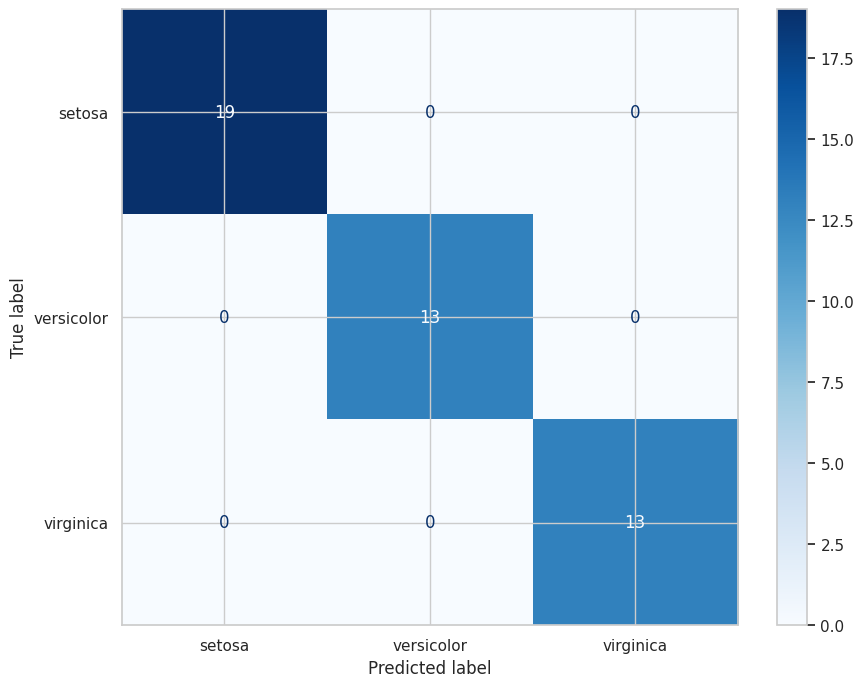

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test.to_numpy().argmax(axis=1),
    np.argmax(y_pred, axis=1),
display_labels=iris.target_names,
cmap=plt.cm.Blues,
ax=ax)

**Receiver Operating Charecteristic (ROC)**

Die ROC Kurve misst die Modellgüte auf Basis der Rate der Fehlklassifikationen, beginnend bei jenen Datenpunkten, für die der Klassifikator die höchste Wahrscheinlichkeit einer Klassenzugehörigkeit angibt. Die Area under the Curve (AUC) bildet dabei die Fläche unterhalt der ROC Kurve ab. Dabei entspricht ein Wert von 1 einer perfekten Klassifikation und ein Wert von 0,5 einer welche äquivalent zu einem Zufallsexperiment mit zwei Möglichkeiten ist.

> _Hinweis_:
> Es gibt keine Informationen wie sicher sich das Model bei der Vorhersage war. Bei Multiclass Classification nur bedingt aussagekräftig

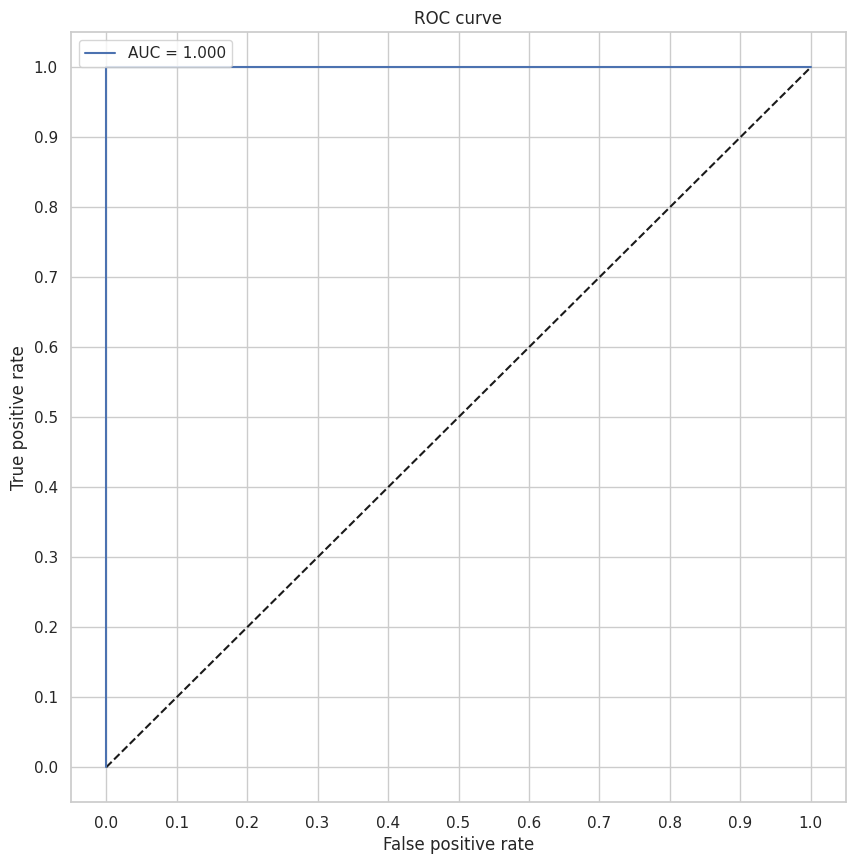

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

fpr, tpr, threshold = roc_curve(y_test.to_numpy().ravel(), y_pred.ravel())

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
ax.set(
    xlabel="False positive rate",
    ylabel="True positive rate",
    title="ROC curve",
    xticks=np.arange(0, 1.1, 0.1),
    yticks=np.arange(0, 1.1, 0.1),
)
ax.legend(loc="upper left")

**K-Fold Crossvalidation**

Vorteile:
* Gefahr von nicht repräsentativen Stichproben sinkt
* Gefahr eines "schlechten" Modells bspw. durch ungünstige Gewichtsinitialisierung sinkt massiv
* odelle können zu einem Ensemble (wird erst in einer der folgenden Übungen behandelt) zusammen gefasst werden zwecks Optimierung der Prediction Performance

Nachteile:
* Deutlich höherer Rechenaufwand, da dasselbe Modell mehrfach gerechnet werden muss

In [19]:
%rm -rf ./logs/

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_ix, test_ix) in enumerate(kf.split(x)):

    mlp = Sequential(name="simple_mlp")
    mlp.add(Dense(8, activation="relu", input_dim=4))
    mlp.add(Dense(3, activation="softmax"))

    compile_model(mlp, metrics)
    fit_model(mlp, x.iloc[train_ix], y.iloc[train_ix])
    evalate_model(mlp, x.iloc[test_ix], y.iloc[test_ix])

Epoch 1/15


2023-03-11 08:39:29.632798: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:29.632832: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:29.633038: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.9133 - categorical_accuracy: 0.4128 - top_k_categorical_accuracy: 1.0000 - recall: 0.4128 - precision: 0.4128 - true_positives: 45.0000 - false_positives: 64.0000 - true_negatives: 154.0000 - false_negatives: 64.0000

2023-03-11 08:39:30.471683: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:30.471713: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:30.563621: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:30.564311: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:30.564536: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:29/plugins/profile/2023_03_11_08_39_30/fedora.xplane.pb


3/3 [==============================] - 1s 337ms/step - loss: 1.7850 - categorical_accuracy: 0.3191 - top_k_categorical_accuracy: 1.0000 - recall: 0.3191 - precision: 0.3237 - true_positives: 45.0000 - false_positives: 94.0000 - true_negatives: 188.0000 - false_negatives: 96.0000 - val_loss: 1.6830 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 24.0000 - val_true_negatives: 24.0000 - val_false_negatives: 24.0000
Epoch 2/15
3/3 [==============================] - 0s 40ms/step - loss: 1.1753 - categorical_accuracy: 0.3125 - top_k_categorical_accuracy: 1.0000 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - false_positives: 26.0000 - true_negatives: 166.0000 - false_negatives: 96.0000 - val_loss: 2.0415 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0

1/1 [==============================] - 0s 19ms/step - loss: 0.5008 - categorical_accuracy: 0.7000 - top_k_categorical_accuracy: 1.0000 - recall: 0.7000 - precision: 0.7000 - true_positives: 21.0000 - false_positives: 9.0000 - true_negatives: 51.0000 - false_negatives: 9.0000

    Loss:               0.501
    Accuracy:           70.00%
    Top K Accuracy:     70.00%

    Recall:             1.000
    Precision           0.700

    True Positives      21
    False Positives     9
    True Negatives      51
    False Negatives     9
    
Epoch 1/15


2023-03-11 08:39:32.347203: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:32.347245: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:32.347348: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.7614 - categorical_accuracy: 0.5638 - top_k_categorical_accuracy: 1.0000 - recall: 0.3085 - precision: 0.4603 - true_positives: 29.0000 - false_positives: 34.0000 - true_negatives: 154.0000 - false_negatives: 65.0000

2023-03-11 08:39:33.026132: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:33.026160: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:33.083873: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:33.084645: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:33.084985: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:32/plugins/profile/2023_03_11_08_39_33/fedora.xplane.pb


3/3 [==============================] - 1s 192ms/step - loss: 1.6761 - categorical_accuracy: 0.5635 - top_k_categorical_accuracy: 1.0000 - recall: 0.2698 - precision: 0.4250 - true_positives: 34.0000 - false_positives: 46.0000 - true_negatives: 206.0000 - false_negatives: 92.0000 - val_loss: 1.1960 - val_categorical_accuracy: 0.0417 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 48.0000 - val_false_negatives: 24.0000
Epoch 2/15
3/3 [==============================] - 0s 34ms/step - loss: 1.4686 - categorical_accuracy: 0.4167 - top_k_categorical_accuracy: 1.0000 - recall: 0.0208 - precision: 0.0500 - true_positives: 2.0000 - false_positives: 38.0000 - true_negatives: 154.0000 - false_negatives: 94.0000 - val_loss: 1.3535 - val_categorical_accuracy: 0.0417 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_t

1/1 [==============================] - 0s 20ms/step - loss: 0.3551 - categorical_accuracy: 0.9000 - top_k_categorical_accuracy: 1.0000 - recall: 0.9000 - precision: 0.9000 - true_positives: 27.0000 - false_positives: 3.0000 - true_negatives: 57.0000 - false_negatives: 3.0000

    Loss:               0.355
    Accuracy:           90.00%
    Top K Accuracy:     90.00%

    Recall:             1.000
    Precision           0.900

    True Positives      27
    False Positives     3
    True Negatives      57
    False Negatives     3
    
Epoch 1/15


2023-03-11 08:39:34.547078: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:34.547111: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:34.547199: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 3.3538 - categorical_accuracy: 0.5745 - top_k_categorical_accuracy: 1.0000 - recall: 0.5745 - precision: 0.5745 - true_positives: 54.0000 - false_positives: 40.0000 - true_negatives: 148.0000 - false_negatives: 40.0000

2023-03-11 08:39:35.258696: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:35.258731: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:35.310667: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:35.311097: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:35.311304: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:34/plugins/profile/2023_03_11_08_39_35/fedora.xplane.pb


3/3 [==============================] - 1s 186ms/step - loss: 3.2995 - categorical_accuracy: 0.5159 - top_k_categorical_accuracy: 1.0000 - recall: 0.5159 - precision: 0.5159 - true_positives: 65.0000 - false_positives: 61.0000 - true_negatives: 191.0000 - false_negatives: 61.0000 - val_loss: 1.8936 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 24.0000 - val_true_negatives: 24.0000 - val_false_negatives: 24.0000
Epoch 2/15
3/3 [==============================] - 0s 34ms/step - loss: 2.3613 - categorical_accuracy: 0.3958 - top_k_categorical_accuracy: 1.0000 - recall: 0.3958 - precision: 0.3958 - true_positives: 38.0000 - false_positives: 58.0000 - true_negatives: 134.0000 - false_negatives: 58.0000 - val_loss: 0.7423 - val_categorical_accuracy: 0.4167 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.3750 - val_precision: 0.3913 - val_true_po

1/1 [==============================] - 0s 24ms/step - loss: 0.4329 - categorical_accuracy: 0.7667 - top_k_categorical_accuracy: 1.0000 - recall: 0.7667 - precision: 0.7667 - true_positives: 23.0000 - false_positives: 7.0000 - true_negatives: 53.0000 - false_negatives: 7.0000

    Loss:               0.433
    Accuracy:           76.67%
    Top K Accuracy:     76.67%

    Recall:             1.000
    Precision           0.767

    True Positives      23
    False Positives     7
    True Negatives      53
    False Negatives     7
    
Epoch 1/15


2023-03-11 08:39:36.765973: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:36.766025: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:36.766151: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.6932 - categorical_accuracy: 0.5532 - top_k_categorical_accuracy: 1.0000 - recall: 0.5532 - precision: 0.5532 - true_positives: 52.0000 - false_positives: 42.0000 - true_negatives: 146.0000 - false_negatives: 42.0000

2023-03-11 08:39:37.435553: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:37.435583: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:37.485331: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:37.485783: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:37.485979: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:36/plugins/profile/2023_03_11_08_39_37/fedora.xplane.pb


3/3 [==============================] - 1s 189ms/step - loss: 1.6933 - categorical_accuracy: 0.5000 - top_k_categorical_accuracy: 1.0000 - recall: 0.5000 - precision: 0.5000 - true_positives: 63.0000 - false_positives: 63.0000 - true_negatives: 189.0000 - false_negatives: 63.0000 - val_loss: 1.7246 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 21.0000 - val_true_negatives: 27.0000 - val_false_negatives: 24.0000
Epoch 2/15
3/3 [==============================] - 0s 32ms/step - loss: 1.3941 - categorical_accuracy: 0.3229 - top_k_categorical_accuracy: 1.0000 - recall: 0.1250 - precision: 0.2069 - true_positives: 12.0000 - false_positives: 46.0000 - true_negatives: 146.0000 - false_negatives: 84.0000 - val_loss: 1.5250 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 -

1/1 [==============================] - 0s 22ms/step - loss: 0.9129 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 1.0000 - recall: 0.5000 - precision: 0.5556 - true_positives: 15.0000 - false_positives: 12.0000 - true_negatives: 48.0000 - false_negatives: 15.0000

    Loss:               0.913
    Accuracy:           60.00%
    Top K Accuracy:     55.56%

    Recall:             1.000
    Precision           0.500

    True Positives      15
    False Positives     12
    True Negatives      48
    False Negatives     15
    
Epoch 1/15


2023-03-11 08:39:38.964682: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:38.964720: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:38.964824: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.3181 - categorical_accuracy: 0.5106 - top_k_categorical_accuracy: 1.0000 - recall: 0.4787 - precision: 0.4945 - true_positives: 45.0000 - false_positives: 46.0000 - true_negatives: 142.0000 - false_negatives: 49.0000

2023-03-11 08:39:39.669862: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:39.669899: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:39.722592: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:39.723076: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:39.723279: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:38/plugins/profile/2023_03_11_08_39_39/fedora.xplane.pb


3/3 [==============================] - 1s 195ms/step - loss: 1.3540 - categorical_accuracy: 0.4524 - top_k_categorical_accuracy: 1.0000 - recall: 0.4286 - precision: 0.4390 - true_positives: 54.0000 - false_positives: 69.0000 - true_negatives: 183.0000 - false_negatives: 72.0000 - val_loss: 3.8054 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 24.0000 - val_true_negatives: 24.0000 - val_false_negatives: 24.0000
Epoch 2/15
3/3 [==============================] - 0s 36ms/step - loss: 1.1334 - categorical_accuracy: 0.4583 - top_k_categorical_accuracy: 1.0000 - recall: 0.4271 - precision: 0.4940 - true_positives: 41.0000 - false_positives: 42.0000 - true_negatives: 150.0000 - false_negatives: 55.0000 - val_loss: 3.1232 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 -

1/1 [==============================] - 0s 22ms/step - loss: 0.8246 - categorical_accuracy: 0.6000 - top_k_categorical_accuracy: 1.0000 - recall: 0.5333 - precision: 0.5714 - true_positives: 16.0000 - false_positives: 12.0000 - true_negatives: 48.0000 - false_negatives: 14.0000

    Loss:               0.825
    Accuracy:           60.00%
    Top K Accuracy:     57.14%

    Recall:             1.000
    Precision           0.533

    True Positives      16
    False Positives     12
    True Negatives      48
    False Negatives     14
    


In [21]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 10360), started 0:00:13 ago. (Use '!kill 10360' to kill it.)

## Regularization

Regularisierung wird verwendet, um Overfittig beim Trainieren eines Models entgegenzuwirken, sowie die Komplexität in einem neuronalen Netz zu reduzieren. Dabei können Early Stopping, Weight Constraining, Weight Penalizing und Droupout verwendet werden. Die letzten beiden davon können ebenso zur Reduktion der omplexität des Netzes verwendet werden.

Methoden zur Regularisierung:
* Early Stopping
* Weight oriented:
    * Weight Penalizing: L1 (Lasso), L2 (Ridge), L1L2 (ElasticNet)
    * Weight Constraining: Unit Norm, Max Norm, Min-Max Norm
* Network oriented:
    * Network agnostic: Vanilla Dropout, Gaussian Dropout, Stand-out

In [22]:
mlp = Sequential(name="simple_mlp")
mlp.add(Dense(8, activation="relu", input_dim=4))
mlp.add(Dense(3, activation="softmax"))

compile_model(mlp, metrics)
fit_model(mlp, x_train, y_train)
evalate_model(mlp, x_test, y_test)

Epoch 1/15


2023-03-11 08:39:41.259457: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:41.259505: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:41.259611: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 5.5573 - categorical_accuracy: 0.3830 - top_k_categorical_accuracy: 1.0000 - recall: 0.3617 - precision: 0.3696 - true_positives: 34.0000 - false_positives: 58.0000 - true_negatives: 130.0000 - false_negatives: 60.0000

2023-03-11 08:39:42.065945: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:42.065993: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:42.125166: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:42.125677: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:42.125906: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:41/plugins/profile/2023_03_11_08_39_42/fedora.xplane.pb


3/3 [==============================] - 1s 229ms/step - loss: 5.0983 - categorical_accuracy: 0.3947 - top_k_categorical_accuracy: 1.0000 - recall: 0.3772 - precision: 0.3839 - true_positives: 43.0000 - false_positives: 69.0000 - true_negatives: 159.0000 - false_negatives: 71.0000 - val_loss: 5.2082 - val_categorical_accuracy: 0.1905 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.1905 - val_precision: 0.1905 - val_true_positives: 4.0000 - val_false_positives: 17.0000 - val_true_negatives: 25.0000 - val_false_negatives: 17.0000
Epoch 2/15
3/3 [==============================] - 0s 43ms/step - loss: 3.9557 - categorical_accuracy: 0.3214 - top_k_categorical_accuracy: 1.0000 - recall: 0.2619 - precision: 0.2785 - true_positives: 22.0000 - false_positives: 57.0000 - true_negatives: 111.0000 - false_negatives: 62.0000 - val_loss: 3.9865 - val_categorical_accuracy: 0.1905 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0476 - val_precision: 0.0556 - val_true_positives: 1.0000 

2/2 [==============================] - 0s 5ms/step - loss: 1.0714 - categorical_accuracy: 0.2000 - top_k_categorical_accuracy: 1.0000 - recall: 0.0000e+00 - precision: 0.0000e+00 - true_positives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 90.0000 - false_negatives: 45.0000

    Loss:               1.071
    Accuracy:           20.00%
    Top K Accuracy:     0.00%

    Recall:             1.000
    Precision           0.000

    True Positives      0
    False Positives     0
    True Negatives      90
    False Negatives     45
    


In [23]:
mlp_reg = Sequential(name="simple_mlp")
mlp_reg.add(Dense(8, activation="relu", input_dim=4, kernel_regularizer=L1(l1=0.01)))
mlp_reg.add(Dense(3, activation="softmax"))

compile_model(mlp_reg, metrics)
fit_model(mlp_reg, x_train, y_train)
evalate_model(mlp_reg, x_test, y_test)

Epoch 1/15


2023-03-11 08:39:43.761942: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:43.761970: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:43.762060: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.4441 - categorical_accuracy: 0.3028 - top_k_categorical_accuracy: 1.0000 - recall: 0.2202 - precision: 0.3750 - true_positives: 24.0000 - false_positives: 40.0000 - true_negatives: 178.0000 - false_negatives: 85.0000

2023-03-11 08:39:44.518558: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:44.518584: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:44.567878: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:44.568650: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:44.568947: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:43/plugins/profile/2023_03_11_08_39_44/fedora.xplane.pb


3/3 [==============================] - 1s 201ms/step - loss: 1.4371 - categorical_accuracy: 0.3023 - top_k_categorical_accuracy: 1.0000 - recall: 0.2326 - precision: 0.3571 - true_positives: 30.0000 - false_positives: 54.0000 - true_negatives: 204.0000 - false_negatives: 99.0000 - val_loss: 1.2583 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.2857 - val_precision: 0.4615 - val_true_positives: 6.0000 - val_false_positives: 7.0000 - val_true_negatives: 35.0000 - val_false_negatives: 15.0000
Epoch 2/15
3/3 [==============================] - 0s 38ms/step - loss: 1.2582 - categorical_accuracy: 0.3571 - top_k_categorical_accuracy: 1.0000 - recall: 0.1190 - precision: 0.2500 - true_positives: 10.0000 - false_positives: 30.0000 - true_negatives: 138.0000 - false_negatives: 74.0000 - val_loss: 1.1593 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 

2/2 [==============================] - 0s 5ms/step - loss: 0.6468 - categorical_accuracy: 0.8889 - top_k_categorical_accuracy: 1.0000 - recall: 0.6889 - precision: 1.0000 - true_positives: 31.0000 - false_positives: 0.0000e+00 - true_negatives: 90.0000 - false_negatives: 14.0000

    Loss:               0.647
    Accuracy:           88.89%
    Top K Accuracy:     100.00%

    Recall:             1.000
    Precision           0.689

    True Positives      31
    False Positives     0
    True Negatives      90
    False Negatives     14
    


In [24]:
def print_layer_weights(model):
    for layer in model.layers:
        print(f"""
Name des Layers: {layer.name}
Kernel Gewichte: {layer.kernel.numpy()}
Bias Gewichte: {layer.bias.numpy()}
        """)

print_layer_weights(mlp)
print_layer_weights(mlp_reg)


Name des Layers: dense_12
Kernel Gewichte: [[-0.29473224 -0.11504048  0.2114082   0.01301102  0.02089459 -0.5965682
  -0.40046838 -0.33590817]
 [ 0.05702753 -0.6541287  -0.57973903 -0.7073155  -0.57895577  0.12804127
  -0.3573011   0.25115573]
 [ 0.6761506  -0.52760655 -0.09234907  0.40791234  0.32759959 -0.24370268
  -0.54659337 -0.21461073]
 [-0.25210488  0.5970662  -0.11875595 -0.64183134 -0.10453904 -0.03022367
   0.16993946  0.14234388]]
Bias Gewichte: [-0.01619308  0.         -0.17339002 -0.24243186 -0.2669778   0.
  0.          0.        ]
        

Name des Layers: dense_13
Kernel Gewichte: [[-1.9821903e-01  5.1050621e-01  1.7423744e-01]
 [-4.7065258e-01 -2.5359130e-01 -3.6535624e-01]
 [ 6.5184772e-02 -5.7702935e-01  4.8094025e-01]
 [ 4.6579984e-01 -7.3152478e-05 -2.5274286e-01]
 [ 4.5193744e-01 -2.2807351e-01 -1.9866340e-01]
 [-2.5022104e-01  2.5008863e-01 -2.0006973e-01]
 [-1.4139616e-01  5.3264099e-01 -6.1932367e-01]
 [-4.8922169e-01 -2.6498497e-01  5.1164228e-01]]
Bias Gew

In [25]:
mlp_reg = Sequential(name="simple_mlp")
mlp_reg.add(Dense(8, activation="relu", input_dim=4, kernel_regularizer=L1(l1=0.01),
                  kernel_constraint=MaxNorm(1.5)))
mlp_reg.add(Dropout(0.2))
mlp_reg.add(Dense(3, activation="softmax"))

compile_model(mlp_reg, metrics)
fit_model(mlp_reg, x_train, y_train, additional_callbacks=[EarlyStopping(monitor='loss',
                                                                         patience=3)])
evalate_model(mlp_reg, x_test, y_test)

Epoch 1/15


2023-03-11 08:39:46.176420: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:46.176452: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:46.176544: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.5074 - categorical_accuracy: 0.5780 - top_k_categorical_accuracy: 1.0000 - recall: 0.4771 - precision: 0.6500 - true_positives: 52.0000 - false_positives: 28.0000 - true_negatives: 190.0000 - false_negatives: 57.0000

2023-03-11 08:39:47.306935: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:39:47.306975: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:39:47.379844: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:39:47.380701: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:39:47.381058: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:39:46/plugins/profile/2023_03_11_08_39_47/fedora.xplane.pb


3/3 [==============================] - 2s 216ms/step - loss: 1.4841 - categorical_accuracy: 0.5426 - top_k_categorical_accuracy: 1.0000 - recall: 0.4264 - precision: 0.5978 - true_positives: 55.0000 - false_positives: 37.0000 - true_negatives: 221.0000 - false_negatives: 74.0000 - val_loss: 1.1649 - val_categorical_accuracy: 0.4286 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.2381 - val_precision: 0.3333 - val_true_positives: 5.0000 - val_false_positives: 10.0000 - val_true_negatives: 32.0000 - val_false_negatives: 16.0000
Epoch 2/15
3/3 [==============================] - 0s 38ms/step - loss: 1.1666 - categorical_accuracy: 0.4048 - top_k_categorical_accuracy: 1.0000 - recall: 0.2619 - precision: 0.4231 - true_positives: 22.0000 - false_positives: 30.0000 - true_negatives: 138.0000 - false_negatives: 62.0000 - val_loss: 1.0394 - val_categorical_accuracy: 0.5714 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0952 - val_precision: 0.6667 - val_true_positives: 2.0000 

2/2 [==============================] - 0s 7ms/step - loss: 0.6708 - categorical_accuracy: 0.9111 - top_k_categorical_accuracy: 1.0000 - recall: 0.4667 - precision: 1.0000 - true_positives: 21.0000 - false_positives: 0.0000e+00 - true_negatives: 90.0000 - false_negatives: 24.0000

    Loss:               0.671
    Accuracy:           91.11%
    Top K Accuracy:     100.00%

    Recall:             1.000
    Precision           0.467

    True Positives      21
    False Positives     0
    True Negatives      90
    False Negatives     24
    


In [26]:
mlp_reg.summary()

Model: "simple_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8)                 40        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


## Hyperparameter Optimization

Hyperparameter sind all die Parameter, die ein ML-Algorithmus nicht selber lernt. Beispiel hierfür sind die Anzahl der Layer und jeweiligen Neuronen pro Layer (Netz Struktur). Weitere Hyperparameter sind die Aktivierungsfunktion, die ANzahl der Epochen, die Batch-Größe oder der verwendete Optimizer.

In [27]:
def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Input(shape=(4, )))

    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        model.add(Dense(
            hp.Int(f'units_{i}', min_value=4, max_value=32, step=2),
            activation="relu"
        ))

        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"dropout_rate", min_value=0.1, max_value=0.7,
                                            step=0.1)))

    model.add(Dense(3, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=5e-4, step=1e-4)),
        loss="categorical_crossentropy",
        metrics=metrics
    )

    return model

In [28]:
tuner_acc = BayesianOptimization(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory=root_dir / "logs" / f"bayesian_{datetime.now().strftime('%Y.%m.%d-%H:%M:%S')}",
    project_name=f"bayesian_{datetime.now().strftime('%Y.%m.%d-%H:%M:%S')}_categorical_accuracy"
)

tuner_acc.search(x_train, y_train, epochs=15, validation_data=(x_test, y_test),
                 callbacks=[EarlyStopping(monitor='loss', patience=3)])

Trial 10 Complete [00h 00m 03s]
val_categorical_accuracy: 0.35555556416511536

Best val_categorical_accuracy So Far: 0.46666668355464935
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


## Ensembles

Bei einem Ensemble handelt es sich um einen Zusammenschluss mehrerer KI-Modelle. Hierbei gibt es zum Beispiel die Möglichkeit, die den durchschnitt oder das Maximum der unterschiedlichen Modelle zu nehmen. Diese können dabei auch beliebig tief geschachtelt werden.

In [29]:
mlp_1 = Sequential(name="mlp_1")
mlp_1.add(Dense(8, activation="relu", input_dim=4))
mlp_1.add(Dense(3, activation="softmax"))

mlp_2 = Sequential(name="mlp_2")
mlp_2.add(Dense(8, activation="relu", input_dim=4))
mlp_2.add(Dense(4, activation="relu", input_dim=4))
mlp_2.add(Dense(3, activation="softmax"))

In [30]:
models = [mlp_1, mlp_2]

for model in models:
    compile_model(model, metrics)
    fit_model(model, x_train, y_train)

Epoch 1/15


2023-03-11 08:40:26.040133: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:40:26.040158: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:40:26.040330: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


1/3 [=========>....................] - ETA: 1s - loss: 2.8359 - categorical_accuracy: 0.2597 - top_k_categorical_accuracy: 1.0000 - recall: 0.2597 - precision: 0.2597 - true_positives: 20.0000 - false_positives: 57.0000 - true_negatives: 97.0000 - false_negatives: 57.0000

2023-03-11 08:40:26.760628: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:40:26.760666: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


2/3 [===================>..........] - ETA: 1s - loss: 2.2226 - categorical_accuracy: 0.2844 - top_k_categorical_accuracy: 1.0000 - recall: 0.2844 - precision: 0.2844 - true_positives: 31.0000 - false_positives: 78.0000 - true_negatives: 140.0000 - false_negatives: 78.0000

2023-03-11 08:40:28.623398: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:40:28.631963: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:40:28.632218: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:40:26/plugins/profile/2023_03_11_08_40_28/fedora.xplane.pb


3/3 [==============================] - 3s 1s/step - loss: 2.1179 - categorical_accuracy: 0.2791 - top_k_categorical_accuracy: 1.0000 - recall: 0.2636 - precision: 0.2720 - true_positives: 34.0000 - false_positives: 91.0000 - true_negatives: 167.0000 - false_negatives: 95.0000 - val_loss: 1.4892 - val_categorical_accuracy: 0.1905 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.1905 - val_precision: 0.2105 - val_true_positives: 4.0000 - val_false_positives: 15.0000 - val_true_negatives: 27.0000 - val_false_negatives: 17.0000
Epoch 2/15
3/3 [==============================] - 0s 40ms/step - loss: 1.7217 - categorical_accuracy: 0.3214 - top_k_categorical_accuracy: 1.0000 - recall: 0.3095 - precision: 0.3133 - true_positives: 26.0000 - false_positives: 57.0000 - true_negatives: 111.0000 - false_negatives: 58.0000 - val_loss: 1.3504 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.3333 - val_precision: 0.3333 - val_true_positives: 7.0000 - v

Epoch 1/15


2023-03-11 08:40:30.183574: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:40:30.183614: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:40:30.183711: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2/3 [===================>..........] - ETA: 0s - loss: 1.1454 - categorical_accuracy: 0.4941 - top_k_categorical_accuracy: 1.0000 - recall: 0.1294 - precision: 0.5789 - true_positives: 11.0000 - false_positives: 8.0000 - true_negatives: 162.0000 - false_negatives: 74.0000

2023-03-11 08:40:31.020975: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-11 08:40:31.021095: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-11 08:40:31.111218: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-11 08:40:31.112695: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-11 08:40:31.113073: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/delta/project/education/lectures/hsw/wpf-ii-ss2023/notebooks/logs/2023.03.11-08:40:30/plugins/profile/2023_03_11_08_40_31/fedora.xplane.pb


3/3 [==============================] - 1s 231ms/step - loss: 1.1427 - categorical_accuracy: 0.4190 - top_k_categorical_accuracy: 1.0000 - recall: 0.1048 - precision: 0.5789 - true_positives: 11.0000 - false_positives: 8.0000 - true_negatives: 202.0000 - false_negatives: 94.0000 - val_loss: 1.0734 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 42.0000 - val_false_negatives: 21.0000
Epoch 2/15
3/3 [==============================] - 0s 46ms/step - loss: 1.0940 - categorical_accuracy: 0.3571 - top_k_categorical_accuracy: 1.0000 - recall: 0.0119 - precision: 0.1000 - true_positives: 1.0000 - false_positives: 9.0000 - true_negatives: 159.0000 - false_negatives: 83.0000 - val_loss: 1.0202 - val_categorical_accuracy: 0.3333 - val_top_k_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_tru

**Average Ensemble**



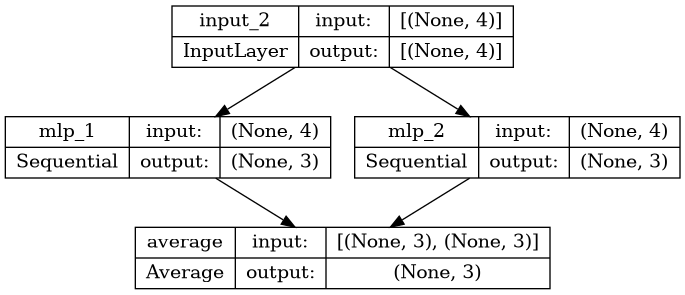

In [31]:
model_input = Input(shape=(4,))
single_mlp_outputs = [model(model_input) for model in models]
ensemble_output = Average()([
    model(model_input)
    for model in models
])
ensemble_model_avg = Model(inputs=model_input, outputs=ensemble_output)
plot_model(ensemble_model_avg, show_shapes=True, show_dtype=False, show_layer_names=True,
           show_layer_activations=True)

In [32]:
compile_model(ensemble_model_avg, metrics)
evalate_model(ensemble_model_avg, x_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.5322 - categorical_accuracy: 0.9394 - top_k_categorical_accuracy: 1.0000 - recall: 0.8182 - precision: 1.0000 - true_positives: 54.0000 - false_positives: 0.0000e+00 - true_negatives: 132.0000 - false_negatives: 12.0000

    Loss:               0.532
    Accuracy:           93.94%
    Top K Accuracy:     100.00%

    Recall:             1.000
    Precision           0.818

    True Positives      54
    False Positives     0
    True Negatives      132
    False Negatives     12
    


**Maximum Ensemble**

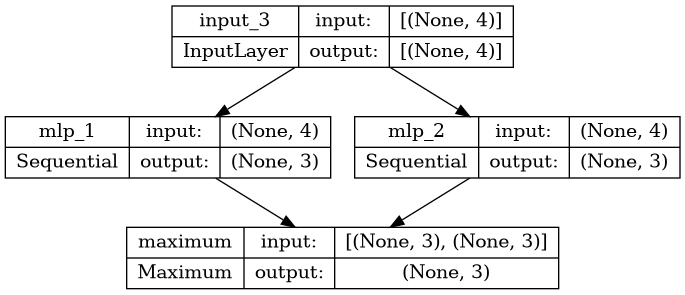

In [33]:
model_input = Input(shape=(4,))
single_mlp_outputs = [model(model_input) for model in models]
ensemble_output = Maximum()([
    model(model_input)
    for model in models
])
ensemble_model_max = Model(inputs=model_input, outputs=ensemble_output)
plot_model(ensemble_model_max, show_shapes=True, show_dtype=False, show_layer_names=True,
           show_layer_activations=True)

In [34]:
compile_model(ensemble_model_max, metrics)
evalate_model(ensemble_model_max, x_test, y_test)

2/2 [==============================] - 0s 10ms/step - loss: 0.5688 - categorical_accuracy: 0.9279 - top_k_categorical_accuracy: 1.0000 - recall: 0.8468 - precision: 0.9792 - true_positives: 94.0000 - false_positives: 2.0000 - true_negatives: 220.0000 - false_negatives: 17.0000

    Loss:               0.569
    Accuracy:           92.79%
    Top K Accuracy:     97.92%

    Recall:             1.000
    Precision           0.847

    True Positives      94
    False Positives     2
    True Negatives      220
    False Negatives     17
    


---

Wahlpflichtach Künstliche Intelligenz II: Praktikum | [Startseite](index.ipynb) | [**>> t.b.d.**]()